**Name:** Sarang Sawant

**Final Project:** Applicatin of ML algorithms on Diamond Data

# Leverage a Google Cloud model Vertex AI to judge the clarity of diamonds

# Phase 1: Data Preparation
This is the most critical phase. Your model's quality is entirely dependent on well-organized data.

## Step 1: Download and Inspect the Dataset
Go to the Kaggle dataset page: Diamond Images Dataset.

Download the dataset and unzip it.

You will find a folder structure like this, which is perfect for our task. The folder names are the labels for the images inside them.
```
diamond-images-dataset/
└── clarity/
    ├── FL/
    │   ├── 1.jpg
    │   └── 2.jpg ...
    ├── IF/
    │   ├── 1.jpg
    │   └── 2.jpg ...
    ├── SI1/
    ├── SI2/
    ├── VS1/
    ├── VS2/
    ├── VVS1/
    └── VVS2/
```
## Step 2: Set up Google Cloud Storage (GCS)
Vertex AI doesn't work with local files; it trains directly from data stored in Google Cloud Storage.

Create a GCS Bucket:

Go to the Google Cloud Storage browser.
Click "Create Bucket".
Give it a globally unique name (e.g., ss_diamonds_dataset).
Choose a Region where Vertex AI is available, like us-central1.
Keep the rest of the settings as default and click "Create".
Upload the Dataset:

Inside your new bucket, click "Upload folder".
Select the clarity folder from the unzipped dataset on your computer.
This will upload the entire folder structure (FL, IF, etc.) and all the images to your bucket. This might take some time.
## Step 3: Create a CSV Index File (Best Practice)

Upload the CSV: After running the script, upload the generated diamond_clarity_index.csv file to the root of your GCS bucket.

# Phase 2: Training the Model in Vertex AI
Now we'll use the Vertex AI console to create and train the model.

## Step 4: Create a Vertex AI Dataset
Navigate to the Vertex AI Datasets page in the Google Cloud Console.
Click "Create".
Give your dataset a name, like diamond-clarity-images.
Select the Image data type.
Choose "Image classification (Single-label)". This is because each diamond image has only one clarity grade.
Click "Create".
# Step 5: Import Your Data
step 5 is automated with create_vertex_ai_dataset_from_gcs function 
On the next screen, select "Select an import file from Cloud Storage".
Browse GCS and select the diamond_clarity_index.csv file you uploaded earlier.
Vertex AI will now start importing your data. It will read the CSV, find the images in GCS, and display them with their correct labels. This can take 10-20 minutes.
Once complete, you can browse the images in the "Browse" tab to verify they are labeled correctly.
## Step 6: Train the Model
![Screenshot 2025-06-22 at 10.35.47 PM.png](<attachment:Screenshot 2025-06-22 at 10.35.47 PM.png>)
Once the dataset import is finished, click the "Train New Model" button.
Training Method:Choose AutoML.
Click Continue.
Model Details: Give your model a name, like diamond_clarity_classifier_v1.
Click Continue.
Training Options:
Optimization: Choose "Best trade-off" for a good balance of speed and accuracy.
Budget: This is crucial for cost. It's measured in "node hours." A good starting point for this dataset is 1-2 node hours. The training will automatically stop when the budget is reached.
Click Continue.
Data Split:
Leave the default split: 80% Training, 10% Validation, 10% Test. Vertex AI will automatically and randomly divide your dataset. This is essential for proper evaluation.
Click "Start Training".
The training process can take several hours (e.g., 2-4 hours for an 8 node-hour budget). You can close the tab; Google will email you when it's done.

# Phase 3: Evaluation and Testing
## Step 7: Evaluate Model Performance
Once training is complete, navigate to the Models section of Vertex AI.
Click on your model name (diamond_clarity_classifier_v1).
Go to the "Evaluate" tab. Here you will see:
Confusion Matrix: This is the most important tool. It shows you exactly which classes the model is confusing. For example, is it often mislabeling a VS1 as a VS2?
Precision and Recall: Key metrics for accuracy on a per-class basis.
Confidence Threshold Slider: You can adjust this to see how it impacts precision and recall.
## Step 8: Deploy and Test the Model
To test the model with new images, you must first deploy it to an Endpoint.

Deploy to Endpoint:

In your model's page, go to the "Deploy & Test" tab.
Click "Deploy to Endpoint".
Give the endpoint a name (e.g., diamond-clarity-endpoint).
Leave the other settings as default and click "Deploy". This can take 15-20 minutes. Deployment incurs an hourly cost, so remember to undeploy it when not in use.
Test in the UI:

Once deployed, you can use the "Upload Image" feature on the same page to upload a new diamond picture (one that wasn't in the training set) and get an instant prediction.
Test Programmatically (Python):
This is how you would integrate the model into an application.
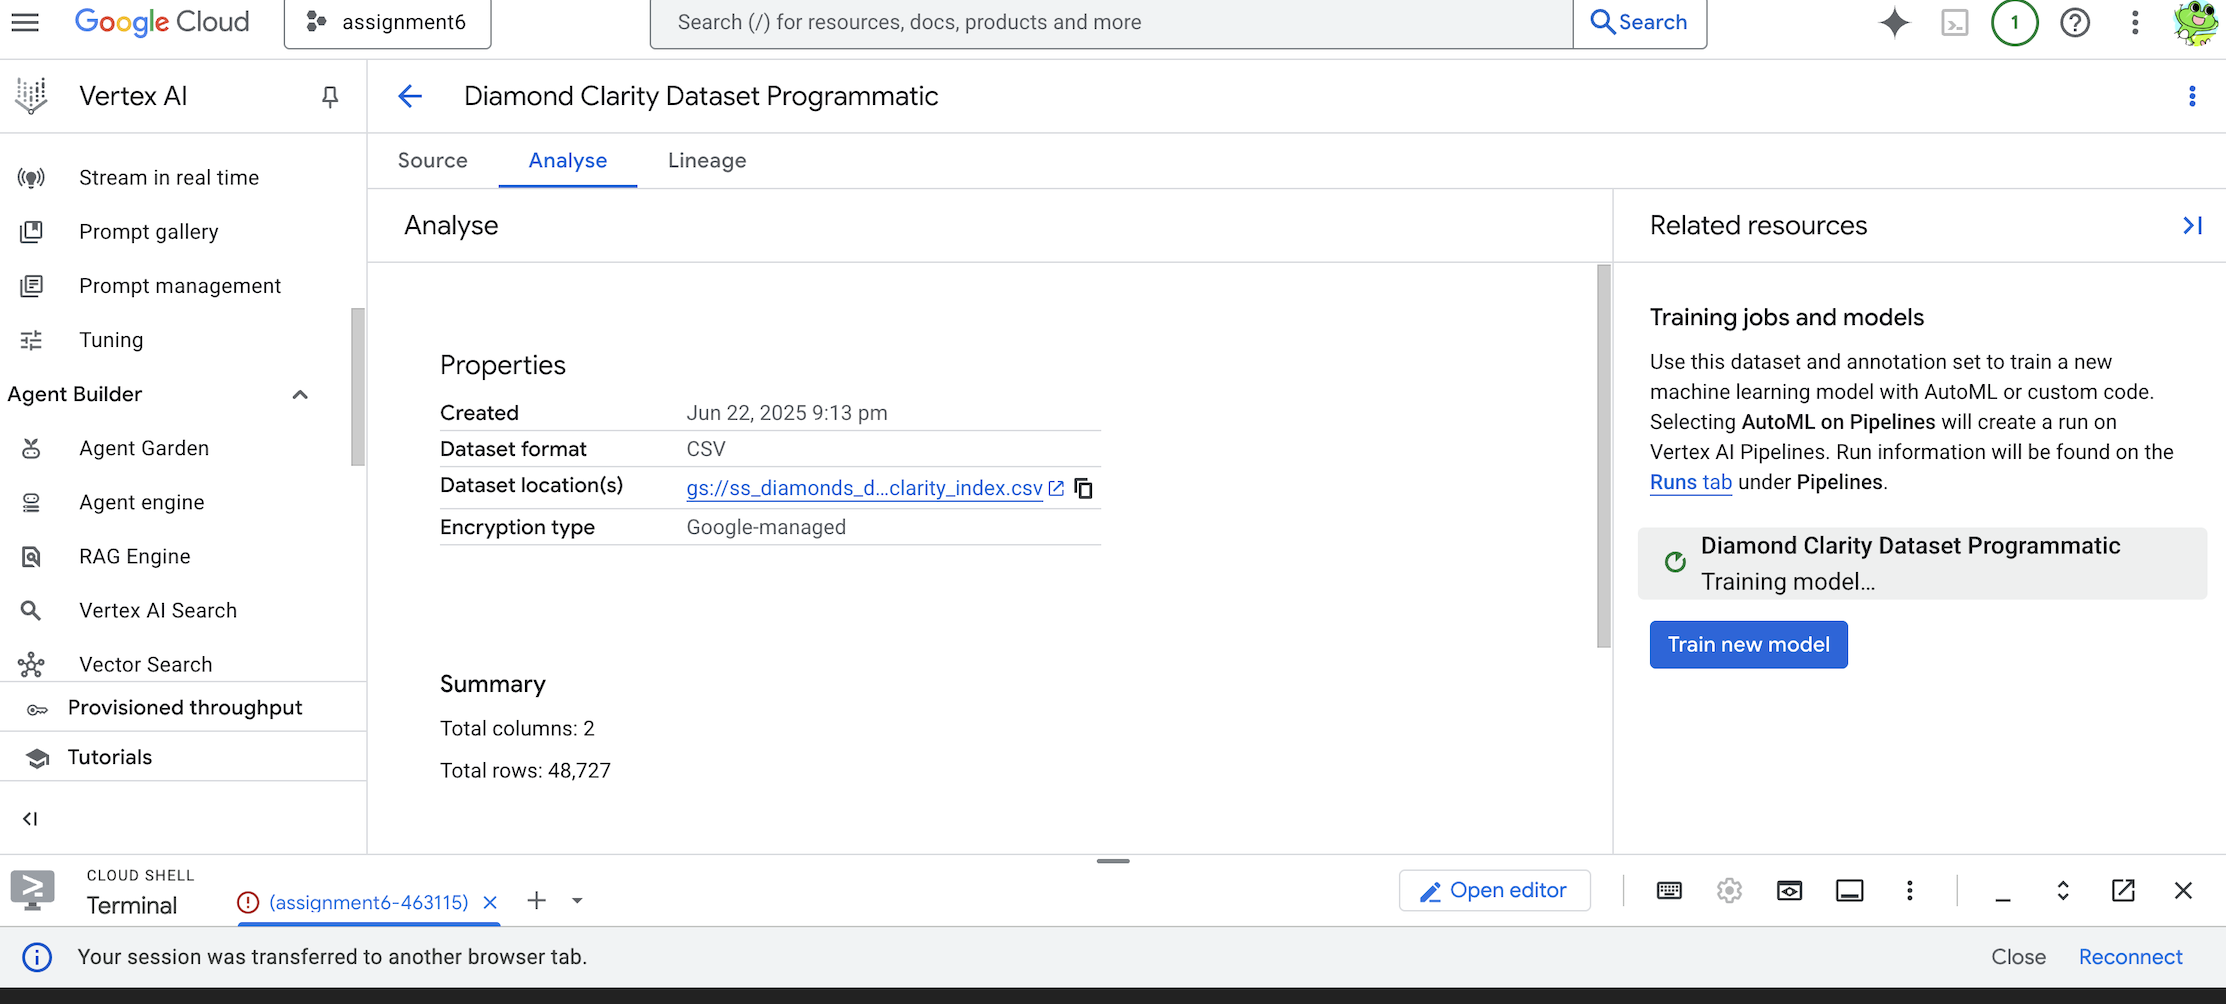

In [32]:
import numpy as np
import pandas as pd
import re
import json
import sys
import os
import ast
import random
from google.cloud import aiplatform

# Set the GOOGLE_APPLICATION_CREDENTIALS environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/sarang.sawant/Documents/GitHub/Assignments/assignment_5_data/key.json"
import vertexai

pd.set_option('display.max_columns', 40)
from vertexai.language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel


In [ ]:
# Phase 1 step 3 
# Paths
PROJECT_ROOT = "/Users/sarang.sawant/Documents/GitHub/Assignments"
BASE_DIR = "/Users/sarang.sawant/Documents/GitHub/Assignments/web_scraped"
CSV_PATH = os.path.join(BASE_DIR, "diamond_data.csv")
TARGET_ROOT = "/Users/sarang.sawant/Documents/GitHub/Assignments/diamond_images"

# Read CSV
df = pd.read_csv(CSV_PATH)
# Ensure 'clarity' column has no nan values
df = df[df['clarity'].notna()]
print(f"CSV file loaded with {len(df)} entries.")
print("Unique clarity labels:", df['clarity'].unique())

# --- Configuration ---
# The name of the GCS bucket you created
BUCKET_NAME = "ss_diamonds_dataset"
# The path to the 'clarity' folder on your local computer
LOCAL_DATA_PATH = TARGET_ROOT

# --- Script ---
all_images = []
# gcs_base_path is where the images will be in the cloud
gcs_base_path = f"gs://{BUCKET_NAME}"

# Walk through the directory
for label_folder in os.listdir(LOCAL_DATA_PATH):
    if os.path.isdir(os.path.join(LOCAL_DATA_PATH, label_folder)):
        label = label_folder # The folder name (e.g., 'FL', 'VS1') is the label
        image_folder_path = os.path.join(LOCAL_DATA_PATH, label_folder)
        if label not in df['clarity'].unique() and label == 'nan':
            print(f"Warning: Label '{label}' not found in CSV clarity column or is NaN. Skipping this folder.")
            continue

        for image_file in os.listdir(image_folder_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Construct the full GCS path for the image
                gcs_path = f"{gcs_base_path}/{label}/{image_file}"
                all_images.append({'gcs_path': gcs_path, 'label': label})

# Create a DataFrame and save to CSV
df = pd.DataFrame(all_images)
df.to_csv("diamond_clarity_index.csv", index=False, header=["path_to_img", "clarity"])

print("CSV file 'diamond_clarity_index.csv' created successfully!")
print(f"It contains {len(df)} image entries.")
print("Example GCS Path:", df['gcs_path'].iloc[0])


CSV file loaded with 48727 entries.
Unique clarity labels: ['SI2' 'SI1' 'VS2' 'VS1' 'VVS1' 'VVS2' 'I2' 'IF' 'I1' 'FL' 'I7' 'I6' 'I5'
 'I4' 'I3' 'SI3' 'SI2-']
CSV file 'diamond_clarity_index.csv' created successfully!
It contains 48727 image entries.
Example GCS Path: gs://ss_diamonds_dataset/VVS1/2072952.jpg


In [40]:
df = pd.read_csv(f'{PROJECT_ROOT}/diamond_clarity_index.csv')

df.head()
df.shape


(48727, 2)

In [41]:
def delete_invalid_gcs_rows(csv_path, invalid_gcs_uris, output_path=None):
    """
    Removes rows from the CSV where the first column matches any of the invalid GCS URIs.
    """
    df = pd.read_csv(csv_path, header=None)
    before = len(df)
    df_clean = df[~df[0].isin(invalid_gcs_uris)]
    after = len(df_clean)
    print(f"Removed {before - after} rows. Remaining: {after}")
    if not output_path:
        output_path = csv_path
    df_clean.to_csv(output_path, index=False, header=False)
    print(f"Cleaned CSV saved to: {output_path}")

# List of invalid GCS URIs
invalid_gcs_uris = [
    "gs://ss_diamonds_dataset/SI2/220416-89.jpg",
    "gs://ss_diamonds_dataset/VS2/2117381.jpg",
    "gs://ss_diamonds_dataset/SI1/1014528.jpg",
    "gs://ss_diamonds_dataset/IF/2130517.jpg",
    "gs://ss_diamonds_dataset/SI1/220566-533.jpg",
    "gs://ss_diamonds_dataset/SI1/2103537.jpg",
    "gs://ss_diamonds_dataset/VS1/220410-164.jpg",
    "gs://ss_diamonds_dataset/VS1/2132207.jpg"
]

# Usage
csv_path = "/Users/sarang.sawant/Documents/GitHub/Assignments/diamond_clarity_index.csv"
# delete_invalid_gcs_rows(csv_path, invalid_gcs_uris)
# not required as the CSV is already cleaned

# copy the cleaned CSV to the bucket
def copy_csv_to_bucket(csv_path, bucket_name):
    """
    Copies the cleaned CSV file to the specified GCS bucket.
    """
    from google.cloud import storage

    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(os.path.basename(csv_path))
    
    blob.upload_from_filename(csv_path)
    print(f"CSV file '{csv_path}' copied to bucket '{bucket_name}'.")
# used command showb below and copied the folder structure to the bucket
# gsutil -m cp -r /Users/sarang.sawant/Documents/GitHub/Assignments/diamond_clarity_index.csv  gs://ss_diamonds_dataset/

In [ ]:
from google.cloud import aiplatform

# Use existing variables: PROJECT_ID, REGION, GCS_SOURCE_URI, DATASET_DISPLAY_NAME, DATASET_DESCRIPTION
GCS_SOURCE_URI = "gs://ss_diamonds_dataset/diamond_clarity_index.csv"
PROJECT_ID = "assignment6-463115""
REGION = "us-central1"
DATASET_DISPLAY_NAME = "Diamond Clarity Dataset Programmatic"
DATASET_DESCRIPTION = "Dataset for diamond clarity classification using Vertex AI Tabular Dataset."
# --- Permission Guidance ---
def print_permission_guidance():
    """Prints essential permission setup instructions."""
    print("\n--- IMPORTANT PERMISSION REQUIREMENTS ---")
    print("1.  **For the Identity (User/Service Account) running this script:**")
    print(f"    This identity MUST have the 'Vertex AI User' role (`roles/aiplatform.user`) on project '{PROJECT_ID}'.")
    print("    If running locally, ensure `gcloud auth application-default login` has been run.")
    print("    If running in Cloud, ensure the attached service account has this role.")
    print("\n2.  **For the Vertex AI Service Agent (to read from GCS):**")
    print(f"    The service account `service-<YOUR_PROJECT_NUMBER>@gcp-sa-aiplatform.iam.gserviceaccount.com`")
    print(f"    MUST have the 'Storage Object Viewer' role (`roles/storage.objectViewer`) on the GCS bucket `gs://ss_diamonds_dataset/`.")
    print("    To find your project number, run `gcloud projects describe YOUR_PROJECT_ID --format='value(projectNumber)'` or check GCP console dashboard.")
    print("-------------------------------------------\n")

# --- Main Script ---
def create_vertex_ai_dataset_from_gcs():
    """
    Creates a Vertex AI Tabular Dataset from a GCS CSV file.
    Handles existence checks and provides permission guidance.
    """
    print_permission_guidance()
    print(f"Using Google Cloud Project ID: {PROJECT_ID}")
    
    print(f"Initializing Vertex AI client for project: {PROJECT_ID}, region: {REGION}")
    aiplatform.init(project=PROJECT_ID, location=REGION)

    gcs_source = [GCS_SOURCE_URI]
    print(f"Attempting to create dataset '{DATASET_DISPLAY_NAME}' from GCS source: {gcs_source}")
    # Import the dataset from the specified GCS CSV file
    # This assumes the CSV is in the correct format for Vertex AI Image Dataset import

    existing_dataset = None
    try:
        # Check if a dataset with the same display name already exists
        print(f"Checking for existing tabular dataset with display name: '{DATASET_DISPLAY_NAME}'...")
        list_response = aiplatform.TabularDataset.list(
            filter=f'display_name="{DATASET_DISPLAY_NAME}"',
            project=PROJECT_ID,
            location=REGION,
        )
        if list_response:
            existing_dataset = list_response[0]
            print(f"Tabular dataset '{DATASET_DISPLAY_NAME}' already exists (Resource Name: {existing_dataset.resource_name}). Skipping creation.")
            dataset = existing_dataset
        else:
            print(f"No existing tabular dataset found with '{DATASET_DISPLAY_NAME}'. Proceeding with creation...")
            # Create the Tabular Dataset.
            dataset = aiplatform.TabularDataset.create(
                display_name=DATASET_DISPLAY_NAME,
                gcs_source=gcs_source,
                sync=True  # Wait for the dataset to be ready
            )
            print(f"\nSuccessfully created Vertex AI Tabular Dataset!")

        print(f"Display Name: {dataset.display_name}")
        print(f"Resource Name: {dataset.resource_name}")
        print(f"Dataset ID: {dataset.name.split('/')[-1]}")
        print(f"Console URL: https://console.cloud.google.com/vertex-ai/datasets/tabular/{dataset.name.split('/')[-1]}/data?project={PROJECT_ID}&region={REGION}")

    except Exception as e:
        print(f"\nAn error occurred during dataset creation:")
        print(f"Error Type: {type(e).__name__}")
        print(f"Error Message: {e}")
        if "Permission denied" in str(e) or "403 Forbidden" in str(e):
            print("\nThis is typically a permission issue. Please review the 'IMPORTANT PERMISSION REQUIREMENTS' above.")
        elif "already exists" in str(e) and existing_dataset is None:
            print(f"A dataset with the display name '{DATASET_DISPLAY_NAME}' might have been created but not caught by pre-check.")
        else:
            print("Please check the error message and ensure all configurations are correct.")


create_vertex_ai_dataset_from_gcs()


--- IMPORTANT PERMISSION REQUIREMENTS ---
1.  **For the Identity (User/Service Account) running this script:**
    This identity MUST have the 'Vertex AI User' role (`roles/aiplatform.user`) on project 'assignment6-463115'.
    If running locally, ensure `gcloud auth application-default login` has been run.
    If running in Cloud, ensure the attached service account has this role.

2.  **For the Vertex AI Service Agent (to read from GCS):**
    The service account `service-<YOUR_PROJECT_NUMBER>@gcp-sa-aiplatform.iam.gserviceaccount.com`
    MUST have the 'Storage Object Viewer' role (`roles/storage.objectViewer`) on the GCS bucket `gs://ss_diamonds_dataset/`.
    To find your project number, run `gcloud projects describe YOUR_PROJECT_ID --format='value(projectNumber)'` or check GCP console dashboard.
-------------------------------------------

Using Google Cloud Project ID: assignment6-463115
Initializing Vertex AI client for project: assignment6-463115, region: us-central1
Attempti

In [52]:
# Generate statistics for the dataset using pandas DataFrame
def generate_dataset_statistics(df):
    """
    Generates and prints statistics for the given pandas DataFrame.
    """
    print("Generating statistics for the dataset...")
    print(f"Number of Rows: {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print("\nColumn-wise statistics:\n")
    for col in df.columns:
        print(f"Column: {col}")
        print(f"  Data Type: {df[col].dtype}")
        print(f"  Unique Values: {df[col].nunique()}")
        print(f"  Missing Values: {df[col].isnull().sum()}")
        print(f"  Sample Values: {df[col].unique()[:5]}")
        print()
    print("Statistics generation complete.")

# Use the already loaded DataFrame 'df'
generate_dataset_statistics(df)

Generating statistics for the dataset...
Number of Rows: 48727
Number of Columns: 2

Column-wise statistics:

Column: path_to_img
  Data Type: object
  Unique Values: 48727
  Missing Values: 0
  Sample Values: ['gs://ss_diamonds_dataset/VVS1/2072952.jpg'
 'gs://ss_diamonds_dataset/VVS1/220637-38.jpg'
 'gs://ss_diamonds_dataset/VVS1/2091377.jpg'
 'gs://ss_diamonds_dataset/VVS1/220345-7.jpg'
 'gs://ss_diamonds_dataset/VVS1/2103615.jpg']

Column: clarity
  Data Type: object
  Unique Values: 17
  Missing Values: 0
  Sample Values: ['VVS1' 'VS1' 'I7' 'SI1' 'I6']

Statistics generation complete.


In [59]:

import base64

def predict_image_clarity(
    project_id: str,
    endpoint_id: str,
    image_path: str,
    location: str = "us-central1"
):
    """Sends an image to the Vertex AI endpoint for prediction."""
    aiplatform.init(project=project_id, location=location)

    # Get the endpoint
    endpoint = aiplatform.Endpoint(endpoint_id)

    # Read the image file and encode it to base64
    with open(image_path, "rb") as f:
        file_content = f.read()
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    # NOTE: For Vertex AI image endpoints, the instance key should be "content" for raw image bytes,
    # but for tabular endpoints, you must send a dict with the correct column names.
    # Since your endpoint expects a struct with "path_to_img", send the GCS path, not the image bytes.

    # If the endpoint expects a GCS path (tabular/image classification), use:
    instance = {"path_to_img": image_path}
    instances = [instance]
    # Remove the previous instance/instances definition above this line.

    # Make the prediction request
    prediction_response = endpoint.predict(instances=instances)

    # Parse the response
    predictions = prediction_response.predictions
    for prediction in predictions:
        # Try both possible key sets
        if 'displayNames' in prediction and 'confidences' in prediction:
            labels = prediction['displayNames']
            confidence_scores = prediction['confidences']
        elif 'labels' in prediction and 'scores' in prediction:
            labels = prediction['labels']
            confidence_scores = prediction['scores']
        else:
            # fallback: print the raw prediction
            print("--- Raw Prediction ---")
            print(prediction)
            predicted_index = np.argmax(prediction['scores'])
            predicted_class = prediction['classes'][predicted_index]
            predicted_score = prediction['scores'][predicted_index]
            print(f"Predicted class: {predicted_class} (confidence: {predicted_score:.2f})")
            continue

        # Combine labels and scores and sort by confidence
        results = sorted(zip(labels, confidence_scores), key=lambda x: x[1], reverse=True)

        print("--- Prediction Results ---")
        for label, score in results:
            print(f"Clarity: {label}, Confidence: {score:.2f}")

# Use existing variables for project and model details
predict_image_clarity(PROJECT_ID, ENDPOINT_ID, IMAGE_FILE)


--- Raw Prediction ---
{'classes': ['VS2', 'SI1', 'SI2', 'VS1', 'VVS2', 'VVS1', 'IF', 'I1', 'I2', 'FL', 'I4', 'I5', 'I3', 'I7', 'SI3', 'SI2-', 'I6'], 'scores': [0.2196764945983887, 0.2084283977746964, 0.2063137739896774, 0.1863095760345459, 0.0974135771393776, 0.05668513476848602, 0.01766339316964149, 0.00569348456338048, 0.0006672180024906993, 0.0006507043144665658, 0.0001252559595741332, 9.640499774832278e-05, 0.0001076343542081304, 4.800924943992868e-05, 3.672363527584821e-05, 4.768409780808724e-05, 3.650780854513869e-05]}
Predicted class: VS2 (confidence: 0.22)
